In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [32]:
import pandas as pd
data_path_warsaw_lisbon = 'warsawlisbon.csv'

try:
    warsaw_lisbon_data = pd.read_csv(data_path_warsaw_lisbon)
    display_warsaw_lisbon_data = warsaw_lisbon_data.head()
except Exception as e:
    display_warsaw_lisbon_data = str(e)

display_warsaw_lisbon_data


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Poland,NaN,Warsaw,1,1,2019,38.8
1,Europe,Poland,NaN,Warsaw,1,2,2019,34.3
2,Europe,Poland,NaN,Warsaw,1,3,2019,28.8
3,Europe,Poland,NaN,Warsaw,1,4,2019,27.3
4,Europe,Poland,NaN,Warsaw,1,5,2019,33.0


C:\Users\PC\AppData\Local\Temp\ipykernel_15508\3280645905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  warsaw_data['Date'] = pd.to_datetime(warsaw_data[['Year', 'Month', 'Day']])
C:\Users\PC\AppData\Local\Temp\ipykernel_15508\3280645905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lisbon_data['Date'] = pd.to_datetime(lisbon_data[['Year', 'Month', 'Day']])


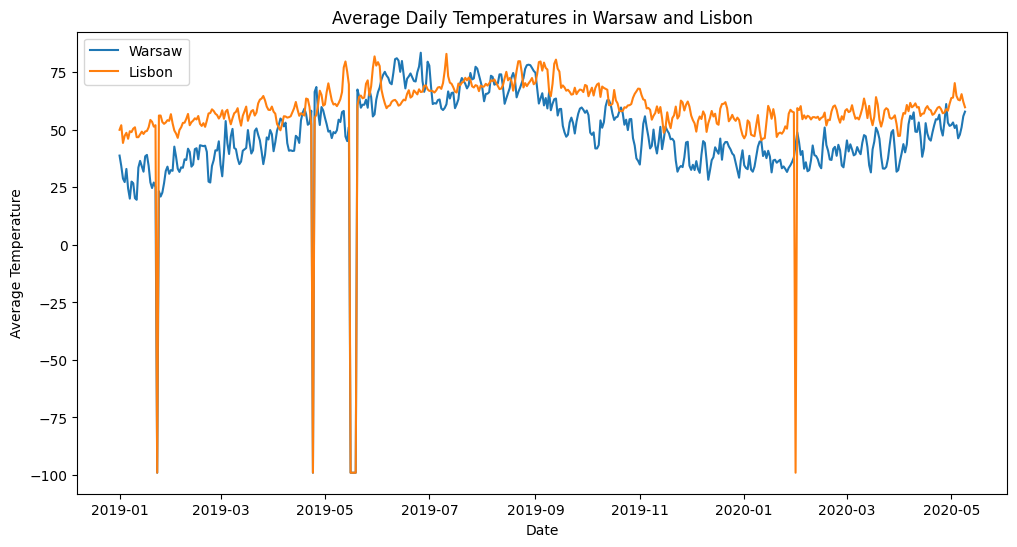

In [33]:
warsaw_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Warsaw']
lisbon_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Lisbon']


warsaw_data['Date'] = pd.to_datetime(warsaw_data[['Year', 'Month', 'Day']])
lisbon_data['Date'] = pd.to_datetime(lisbon_data[['Year', 'Month', 'Day']])

warsaw_data = warsaw_data.sort_values(by='Date')
lisbon_data = lisbon_data.sort_values(by='Date')

plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warsaw')
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lisbon')
plt.title('Average Daily Temperatures in Warsaw and Lisbon')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()


In [25]:
print(warsaw_lisbon_data.head())
print(warsaw_lisbon_data['AvgTemperature'].describe())


   Region Country  State    City  Month  Day  Year  AvgTemperature
0  Europe  Poland    NaN  Warsaw      1    1  1995      -39.988824
1  Europe  Poland    NaN  Warsaw      1    2  1995      -39.989550
2  Europe  Poland    NaN  Warsaw      1    3  1995      -39.990039
3  Europe  Poland    NaN  Warsaw      1    4  1995      -39.990677
4  Europe  Poland    NaN  Warsaw      1    5  1995      -39.991299
count    18532.000000
mean       -39.985946
std          0.002599
min        -40.008745
25%        -39.987075
50%        -39.985548
75%        -39.984229
max        -39.979797
Name: AvgTemperature, dtype: float64


In [54]:
print("Przed konwersją:", warsaw_lisbon_data['AvgTemperature'].head())
warsaw_lisbon_data['AvgTemperature'] = (warsaw_lisbon_data['AvgTemperature'] - 32) * 5/9
print("Po konwersji:", warsaw_lisbon_data['AvgTemperature'].head())


Przed konwersją: 0   -40.0
1   -40.0
2   -40.0
3   -40.0
4   -40.0
Name: AvgTemperature, dtype: float64
Po konwersji: 0   -40.0
1   -40.0
2   -40.0
3   -40.0
4   -40.0
Name: AvgTemperature, dtype: float64


In [35]:
warsaw_lisbon_data['Date'] = pd.to_datetime(warsaw_lisbon_data[['Year', 'Month', 'Day']])
print(warsaw_lisbon_data[['Year', 'Month', 'Day', 'Date']].head())  


   Year  Month  Day       Date
0  2019      1    1 2019-01-01
1  2019      1    2 2019-01-02
2  2019      1    3 2019-01-03
3  2019      1    4 2019-01-04
4  2019      1    5 2019-01-05


In [36]:
warsaw_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Warsaw']
lisbon_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Lisbon']
warsaw_data.set_index('Date', inplace=True)
lisbon_data.set_index('Date', inplace=True)

warsaw_weekly_avg = warsaw_data['AvgTemperature'].resample('W').mean()
lisbon_weekly_avg = lisbon_data['AvgTemperature'].resample('W').mean()

print("Warsaw weekly avg:", warsaw_weekly_avg.head())
print("Lisbon weekly avg:", lisbon_weekly_avg.head())


Warsaw weekly avg: Date
2019-01-06    31.116667
2019-01-13    26.342857
2019-01-20    32.828571
2019-01-27     6.714286
2019-02-03    34.685714
Freq: W-SUN, Name: AvgTemperature, dtype: float64
Lisbon weekly avg: Date
2019-01-06    48.083333
2019-01-13    48.800000
2019-01-20    50.728571
2019-01-27    31.828571
2019-02-03    52.714286
Freq: W-SUN, Name: AvgTemperature, dtype: float64


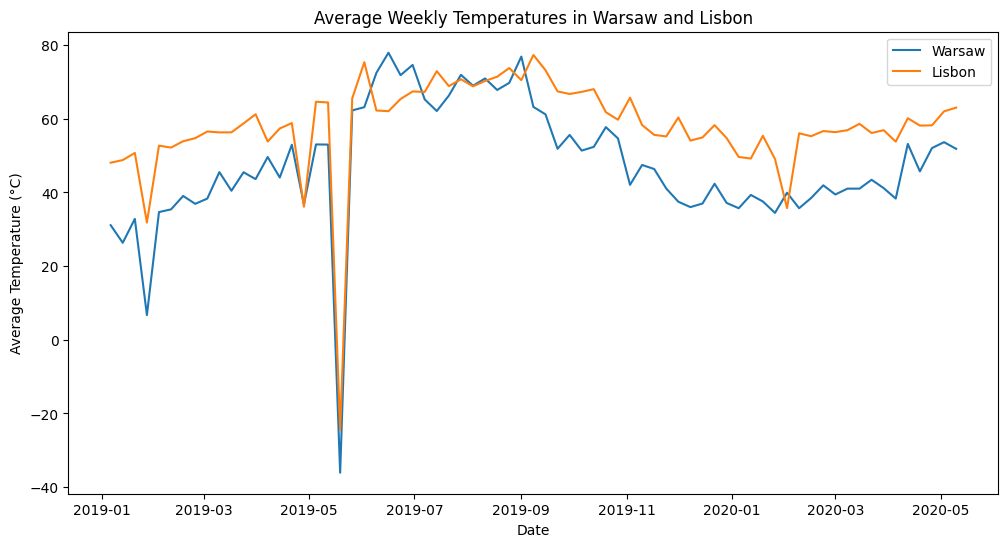

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_weekly_avg.index, warsaw_weekly_avg, label='Warsaw')
plt.plot(lisbon_weekly_avg.index, lisbon_weekly_avg, label='Lisbon')
plt.title('Average Weekly Temperatures in Warsaw and Lisbon')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()
